In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Dec 27 16:51:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir cell
!7z x -aos /content/drive/MyDrive/cell/cell.zip -o/content/cell
!mkdir cell_json
!cp /content/drive/MyDrive/cell/cell_json/annotations_all.json /content/cell_json
!cp /content/drive/MyDrive/cell/cell_json/annotations_train.json /content/cell_json
!cp /content/drive/MyDrive/cell/cell_json/annotations_val.json /content/cell_json


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/cell/                                      1 file, 2478780014 bytes (2364 MiB)

Extracting archive: /content/drive/MyDrive/cell/cell.zip
 48% 4096 Open              --
Path = /content/drive/MyDrive/cell/cell.zip
Type = zip
Physical Size = 2478780014

  0%      0% - LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json                                                                           1% - LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-j_i258zh
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-j_i258zh
     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 74 kB 2.6 MB/s 
     |████████████████████████████████| 145 kB 50.1 MB/s 
     |████████████████████████████████| 130 kB 64.7 MB/s 
     |████████████████████████████████| 843 kB 52.2 MB/s 
     |████████████████████████████████| 749 kB 54.8 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 112 kB 53.0 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5720465 sha256=5d831dc0aba498b91a8818721e61069815edd6874d5a405ec3517e8697ac20e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-dito__u4/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore

In [ ]:
import detectron2
from detectron2.data import detection_utils as utils
from pathlib import Path
import copy
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog,build_detection_train_loader,build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
import detectron2.data.transforms as T
import torch

setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
dataDir=Path('/content/cell')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, '/content/cell_json/annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'/content/cell_json/annotations_val.json', dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[12/28 02:01:37 d2.data.datasets.coco]: Loading /content/cell_json/annotations_train.json takes 1.57 seconds.
[12/28 02:01:37 d2.data.datasets.coco]: Loaded 485 images in COCO format from /content/cell_json/annotations_train.json


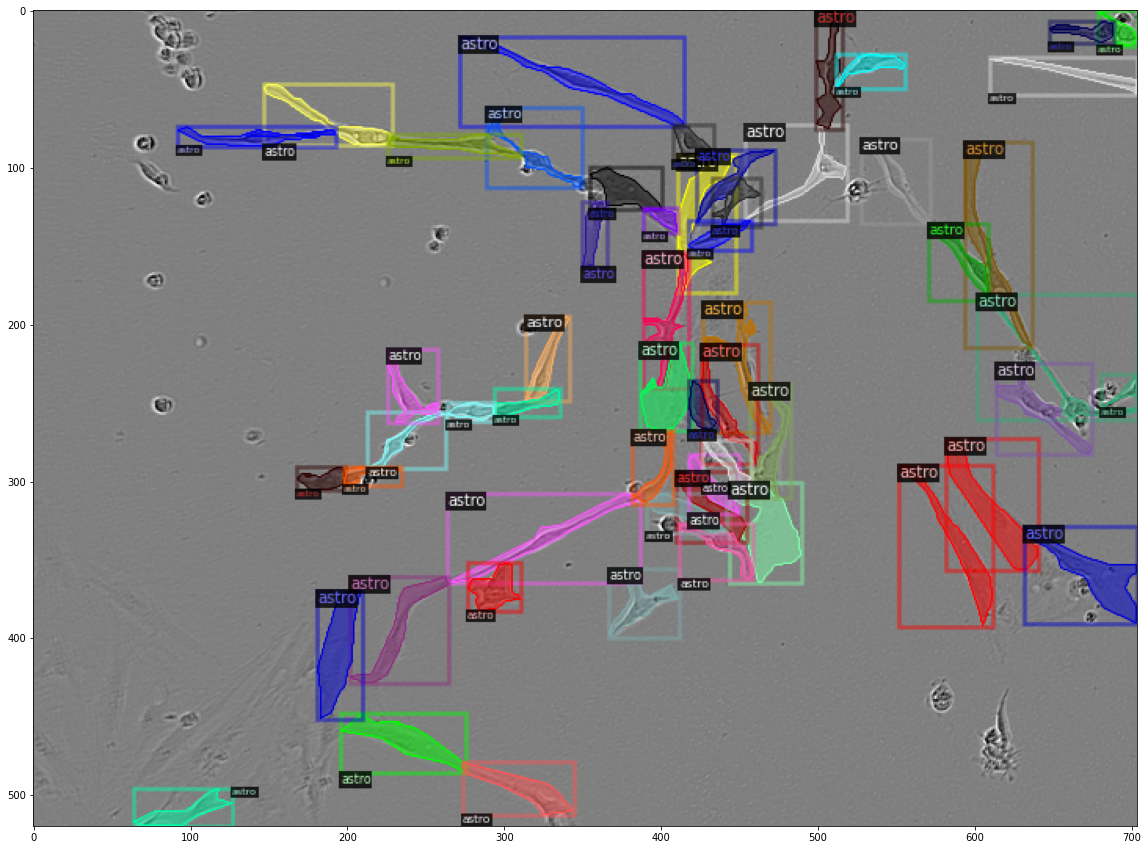

In [ ]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

### Augmentation

In [ ]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
            # T.RandomBrightness(0.9, 1.1),
            # T.RandomContrast(0.9, 1.1),
            # T.RandomSaturation(0.9, 1.1),
            # T.RandomLighting(0.9),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2],mask_format="bitmask")
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

### evaluate


In [ ]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

### training


In [ ]:
print('epoch sum is:',10000/((len(DatasetCatalog.get('sartorius_train'))) // 4))  # 计算我训练多少个epoch

[12/28 02:01:41 d2.data.datasets.coco]: Loading /content/cell_json/annotations_train.json takes 1.26 seconds.
[12/28 02:01:41 d2.data.datasets.coco]: Loaded 485 images in COCO format from /content/cell_json/annotations_train.json
epoch sum is: 82.64462809917356


In [ ]:
(len(DatasetCatalog.get('sartorius_train'))/5)*100

[12/28 02:01:43 d2.data.datasets.coco]: Loaded 485 images in COCO format from /content/cell_json/annotations_train.json


9700.0

In [ ]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.0001 
cfg.SOLVER.MAX_ITER = 9700    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 #似乎64比128好   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  #竞赛要求
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AugTrainer(cfg) # with augmentation
# trainer = Trainer(cfg) # without augmentation
trainer.resume_or_load(resume=False)
trainer.train()


[12/28 02:01:46 d2.data.datasets.coco]: Loading /content/cell_json/annotations_train.json takes 1.20 seconds.
[12/28 02:01:46 d2.data.datasets.coco]: Loaded 485 images in COCO format from /content/cell_json/annotations_train.json
[12/28 02:01:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up):

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[12/28 02:01:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/28 02:02:21 d2.utils.events]:  eta: 2:06:21  iter: 19  total_loss: 7.157  loss_cls: 1.338  loss_box_reg: 0.1885  loss_mask: 0.6934  loss_rpn_cls: 4.544  loss_rpn_loc: 0.398  time: 1.0719  data_time: 0.5203  lr: 1.9981e-06  max_mem: 5055M
[12/28 02:02:43 d2.utils.events]:  eta: 2:14:42  iter: 39  total_loss: 5.57  loss_cls: 1.308  loss_box_reg: 0.2208  loss_mask: 0.6929  loss_rpn_cls: 2.819  loss_rpn_loc: 0.4011  time: 1.0976  data_time: 0.4301  lr: 3.9961e-06  max_mem: 5055M
[12/28 02:03:03 d2.utils.events]:  eta: 2:09:29  iter: 59  total_loss: 3.455  loss_cls: 1.217  loss_box_reg: 0.1907  loss_mask: 0.6916  loss_rpn_cls: 0.8742  loss_rpn_loc: 0.3669  time: 1.0552  data_time: 0.3541  lr: 5.9941e-06  max_mem: 5055M
[12/28 02:03:25 d2.utils.events]:  eta: 2:09:56  iter: 79  total_loss: 2.97  loss_cls: 1.097  loss_box_reg: 0.2615  loss_mask: 0.6907  loss_rpn_cls: 0.5668  loss_rpn_loc: 0.3898  time: 1.0677  data_time: 0.4321  lr: 7.9921e-06  max_mem: 5055M
[12/28 02:03:48 d2.data.datas